In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import LearningRateScheduler, TensorBoard
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

2024-05-01 19:21:37.333625: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-01 19:21:37.336029: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-01 19:21:37.365284: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-01 19:21:38.027782: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
original_df = pd.read_csv('./train.csv')
main_test_df = pd.read_csv('./test.csv')

In [4]:
no_outlier_df = original_df[original_df['Height'] <= 0.3]
no_outlier_df = no_outlier_df[no_outlier_df['Whole weight'] <= 2.25]
no_outlier_df = no_outlier_df[no_outlier_df['Whole weight.1'] <= 1]
no_outlier_df = no_outlier_df[no_outlier_df['Whole weight.2'] <= 0.5]
no_outlier_df = no_outlier_df[no_outlier_df['Shell weight'] <= 0.6]

In [5]:
def generate_features(df):
    df['Min Whole Weight'] = df[['Whole weight', 'Whole weight.1', 'Whole weight.2']].min(axis=1)
    df['Max Whole Weight'] = df[['Whole weight', 'Whole weight.1', 'Whole weight.2']].max(axis=1)
    df['CV Length'] = df['Length'] / df['Length'].mean()

    df['Aspect Ratio'] = df['Length'] / df['Diameter']
    df['Shell Weight Ratio'] = df['Shell weight'] / df['Whole weight']
    df['Density'] = df['Whole weight'] / (df['Length'] * df['Diameter'] * df['Height'])  # Assuming cylinder
    df['Density'] = np.where(df['Density'] == np.inf, 0, df['Density'])
    df['Volume'] = np.pi * (df['Diameter'] / 2) ** 2 * df['Height']  # Assuming cylinder
    df['Length to Height Ratio'] = df['Length'] / df['Height']
    df['Length to Height Ratio'] = np.where(df['Length to Height Ratio'] == np.inf, 0, df['Length to Height Ratio'])

    df['Weight Diff Max-Min'] = df['Max Whole Weight'] - df['Min Whole Weight']
    df['Avg Whole Weight'] = (df['Whole weight'] + df['Whole weight.1'] + df['Whole weight.2']) / 3
    weight_std = df[['Whole weight', 'Whole weight.1', 'Whole weight.2']].std(axis=1)
    df['Std Weight Measures'] = weight_std
    df['CV Whole Weight'] = np.where(weight_std == 0, 0, weight_std / df['Avg Whole Weight'])

    df['Is Male'] = df['Sex'].apply(lambda x: 1 if x == "M" else 0)
    df['Is Female'] = df['Sex'].apply(lambda x: 1 if x == "F" else 0)
    df['Is Infant'] = df['Sex'].apply(lambda x: 1 if x == "I" else 0)
    

    df['Length x Diameter'] = df['Length'] * df['Diameter']
    df['Length x Height'] = df['Length'] * df['Height']
    df['Diameter x Height'] = df['Diameter'] * df['Height']
    df['Length x Shell Weight'] = df['Length'] * df['Shell weight']

    return df

In [6]:
df = generate_features(no_outlier_df.copy())
test_df = generate_features(main_test_df.copy())

In [7]:
scaler = MinMaxScaler()
numerical_features = ['Length', 'Diameter', 'Height', 'Whole weight',
       'Whole weight.1', 'Whole weight.2', 'Shell weight',
       'Min Whole Weight', 'Max Whole Weight', 'CV Length', 'Aspect Ratio',
       'Shell Weight Ratio', 'Density', 'Volume', 'Length to Height Ratio',
       'Weight Diff Max-Min', 'Avg Whole Weight', 'Std Weight Measures',
       'CV Whole Weight','Length x Diameter', 'Length x Height', 'Diameter x Height',
       'Length x Shell Weight']
df[numerical_features] = scaler.fit_transform(df[numerical_features])
test_df[numerical_features] = scaler.transform(test_df[numerical_features])

In [8]:
train_df, valid_df = train_test_split(df, test_size=0.15, random_state=42)
features = ['Is Male', 'Is Female', 'Is Infant'] + numerical_features
target = ['Rings']

In [9]:
X_train, y_train = train_df[features], train_df[target]
X_valid, y_valid = valid_df[features], valid_df[target]
X_test = test_df[features]

In [10]:
model = Sequential()
model.add(Flatten(input_shape=(X_train.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

2024-05-01 19:21:38.635272: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-01 19:21:38.635701: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 26)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,953 (23.25 KB)

 Trainable params: 5,953 (23.25 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
def root_mean_squared_logarithmic_error(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

In [12]:
optimizer = Adam(learning_rate=0.0001)

In [13]:
model.compile(optimizer=optimizer, loss=root_mean_squared_logarithmic_error, metrics=['mae'])

In [14]:
history = model.fit(X_train, y_train, epochs= 20, batch_size=32, validation_data=(X_valid, y_valid))

Epoch 1/20
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 2s 445us/step - loss: 0.7926 - mae: 4.7313 - val_loss: 0.1355 - val_mae: 1.5210
Epoch 2/20
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 1s 415us/step - loss: 0.1348 - mae: 1.5318 - val_loss: 0.1270 - val_mae: 1.4323
Epoch 3/20
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 1s 408us/step - loss: 0.1278 - mae: 1.4542 - val_loss: 0.1223 - val_mae: 1.3801
Epoch 4/20
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 1s 415us/step - loss: 0.1232 - mae: 1.3999 - val_loss: 0.1188 - val_mae: 1.3386
Epoch 5/20
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 1s 420us/step - loss: 0.1201 - mae: 1.3579 - val_loss: 0.1165 - val_mae: 1.3107
Epoch 6/20
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 1s 409us/step - loss: 0.1172 - mae: 1.3232 - val_loss: 0.1151 - val_mae: 1.2918
Epoch 7/20
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 1s 413us/step - loss: 0.1166 - mae: 1.3152 - val_loss: 0.1147 - val_mae: 1.2845
Epoch 8/20
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 1s 414us/step - loss: 0.1165 - mae: 1.3133 - val_loss: 0.1136 - val_mae: 1.2728
Epoch 9/20
2386/2386 ━━━

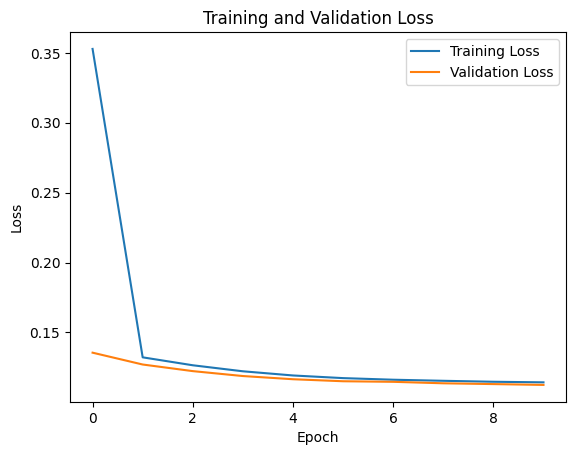

In [15]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [16]:
y_test = model.predict(X_test)
submission = pd.DataFrame()
submission['id'] = test_df['id']
submission['Rings'] = y_test
submission.to_csv('submission.csv', index=False)

1888/1888 ━━━━━━━━━━━━━━━━━━━━ 1s 312us/step
